In [ ]:
import os
from io import open
import glob
import unicodedata
import string

In [ ]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
sns.set()

## Read Files and make dicts of names per language

In [ ]:
def findFiles(path): return glob.glob(path)
all_letters = string.ascii_letters + ".,;-"
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]
category_lines = {}
all_categories = []
for filename in findFiles('data/names/*.txt'):
    category = filename.replace('\\', '/').split('/')[-1].split('.')[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines
n_letters = len(all_letters)
n_categories = len(all_categories)

n_letters, n_categories

In [ ]:
import torch

def letterToIndex(letter):
    return all_letters.find(letter)

def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

print(letterToTensor('J').size())
print(lineToTensor('Jones').size())

In [ ]:
import torch.nn as nn
from torch.autograd import Variable

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return Variable(torch.zeros(1, self.hidden_size))

n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)

In [ ]:
# input_size, hidden_size, num_layers
input_size = 10 # num_features
hidden_size = 20 # cell size
num_layers = 2
batch_size = 3
seq_len = 5

gru = nn.GRU(input_size, hidden_size, num_layers)
input = Variable(torch.randn(seq_len, batch_size, input_size))
h0 = Variable(torch.randn(num_layers, batch_size, hidden_size))
output, hn = gru(input, h0)
output.size() # (seq_len, batch_size, hidden_size)

In [ ]:
lstm = nn.LSTM(input_size, hidden_size, num_layers)
input = Variable(torch.randn(seq_len, batch_size, input_size))
h0 = Variable(torch.randn(num_layers, batch_size, hidden_size))
c0 = Variable(torch.randn(num_layers, batch_size, hidden_size))
output, (hn, cn) = lstm(input, (h0, c0))

In [ ]:
import numpy as np
import pandas as pd

In [ ]:
df = pd.DataFrame()
df['word'] = [w for cat in all_categories for w in category_lines[cat]]
df['target'] = [cat for cat in all_categories for w in category_lines[cat]]

In [ ]:
df.word.apply(len).hist(bins=15, figsize=(10,5))

In [ ]:
plt.figure(figsize=(10,5))
sns.countplot(y=df.target)

In [ ]:
# cleaning data
df = df[df.word != 'ToTheFirstPage']

In [ ]:
df.shape

In [ ]:
df[df.word.apply(lambda x: len(x)>15)]

In [ ]:
max(df.word.apply(len))

In [ ]:
seq_len = max(df.word.apply(len))
batch_size = 32
input_size = n_letters
seq_len, input_size

In [ ]:
def lineToPaddedTensor(word):
    pad_len = seq_len - len(word)
    padded_word = word + '-' * pad_len
    return lineToTensor(padded_word)

In [ ]:
lineToPaddedTensor(df.word[6]).shape

In [ ]:
hidden_size = 20 # cell size
num_layers = 2

gru = nn.GRU(input_size, hidden_size, num_layers)
input = Variable(torch.randn(seq_len, batch_size, input_size))
h0 = Variable(torch.randn(num_layers, batch_size, hidden_size))
output, hn = gru(input, h0)

In [ ]:
input.shape, h0.shape

In [ ]:
idxs = np.random.choice(df.index, batch_size)
batch_words = df.word[idxs]

In [ ]:
def get_batch():
    idxs = np.random.choice(df.index, batch_size)
    batch_words = df.word[idxs]
    batch_targets = df.target[idxs]
    targets_tensor = Variable(torch.LongTensor([
        [all_categories.index(target)] for target in batch_targets
    ]))
    words_tensor = Variable(torch.cat([
        lineToPaddedTensor(word) for word in batch_words
    ], dim=1))
    return batch_words, words_tensor, batch_targets, targets_tensor

In [ ]:
batch_words, words_tensor, batch_targets, targets_tensor = get_batch()

In [ ]:
words_tensor.shape, targets_tensor.shape

In [ ]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers, batch_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.batch_size = batch_size

        self.gru = nn.GRU(input_size, hidden_size, num_layers)
        self.h2o = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, h0):
        output, hn = self.gru(input, h0)
        output = self.h2o(output[-1])
        output = self.softmax(output)
        return output, hn

    def initHidden(self):
        return Variable(torch.randn(self.num_layers, self.batch_size, self.hidden_size))

In [ ]:
import torch.optim as optim

net = RNN(input_size, hidden_size, n_categories, num_layers, batch_size)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

In [ ]:
def train(rnn, words_tensor,  targets_tensor):
    h0 = rnn.initHidden()
#     rnn.zero_grad()
    optimizer.zero_grad()
    output, hn = rnn(words_tensor, h0)
#     print(output.shape, targets_tensor.view(-1).shape)
    loss = criterion(output, targets_tensor.view(-1))
    loss.backward()
    optimizer.step()
    return output, loss.data[0]    

In [ ]:
import time
import math

n_iters = 100000
print_every = 5000
plot_every = 1000

In [ ]:
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

In [ ]:
def categoryFromOutput(output):
    top_n, top_i = output.data.topk(1)
    category_i = int(top_i)
    return all_categories[category_i], category_i

In [170]:
n_categories

18

In [ ]:
start = time.time()

for iter in range(1, n_iters + 1):
    batch_words, words_tensor, batch_targets, targets_tensor = get_batch()
    output, loss = train(net, words_tensor, targets_tensor)
    current_loss += loss
    
    print(iter, end='\r')

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        for y_pred, y, word in zip(output, batch_targets, batch_words):
            guess, guess_i = categoryFromOutput(y_pred)
            correct = '✓' if guess == y else '✗ (%s)' % y
            print('%d %d%% (%s) %.4f %s: %s / %s %s' % (iter, iter / n_iters * 100, 
                                                timeSince(start), loss, word,
                                                y, guess, correct))   

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

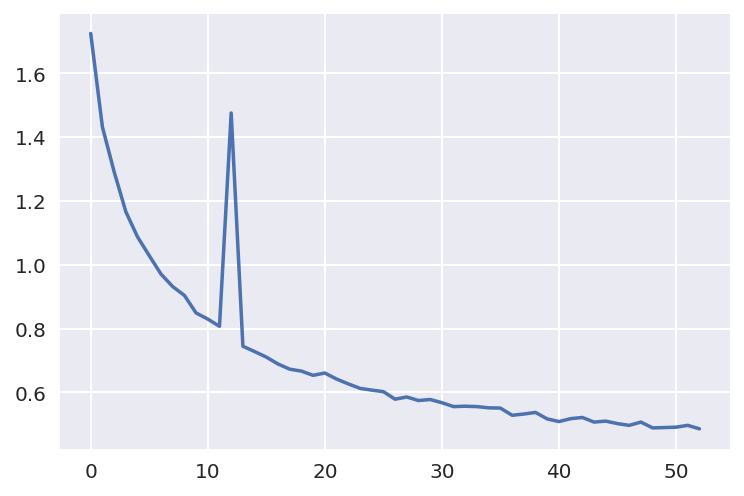

In [203]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
sns.set()

plt.figure()
plt.plot(all_losses)


In [207]:
torch.save(net.state_dict(), 'RNN-weights')

In [ ]:
rnn = RNN()
rnn.load_state_dict(torch.load('RNN-weight'))

In [208]:
torch.save(net, 'RNN')

/home/robert/anaconda3/envs/kaggle/lib/python3.6/site-packages/torch/serialization.py:158: UserWarning: Couldn't retrieve source code for container of type RNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [ ]:
rnn = torch.load('RNN')

In [ ]:
# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# Just return an output given a line
def evaluate(line_tensor):
    hidden = net.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = net(line_tensor[i], hidden)

    return output

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    batch_words, words_tensor, batch_targets, targets_tensor = get_batch()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()